## Load dependencies

In [2]:
# MAKE SURE YOU USE "myenv" WHEN RUNNING THIS NOTEBOOK.

import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model # new!
from keras.layers import Input, concatenate # new!
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

## Set hyperparameters

In [3]:
# output directory name:
output_dir = 'model_output/multiconv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64
n_unique_words = 5000
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# convolutional layer architecture:
n_conv_1 = n_conv_2 = n_conv_3 = 256
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

# dense layer architecture:
n_dense = 256
dropout = 0.2

## Load and preprocess data

In [4]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

In [5]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

## Designing neural network architecture

In [ ]:
'''
Although sequential models constitute the vast majority of deep learning models, there are times when non-sequential 
architectures- which permit onfonote model-design posibilities and are often more complex- could be warranted. (Popular 
aspects of non-sequential models include having multiple model inputs or outputs- potentially at different levels within 
the architecture;e.g., a model could have an additional input or an additional output midway through the architecture- 
sharing the activations of a single layer with multiple other layers, and creating directly acyclic graphs.) In such 
situations, we can take advantage of the Keras 'functional' API, which makes use of the Model class instead of the 
Sequential models we've worked with so far in the book.
As an example of a non-sequential architecture, we decided to riff on our highest performing sentiment classifier, the 
convolutional mode, to see if we could squeeze more juice out of the proverbial lemon. Our idea was to have three parallel 
streams of convolutional layers- each of which takes in word vectors from an Embedding() layer. As in our Convolutional 
Sentiment Classifier notebook, one of these streams eould have a filter length of three tokens. One of the others will have 
a filter of two- so it will specialize in learning word-vector pairs that appear to be relevant to classifying a film review
as having positive or negative sentiment. The third convolutional stream will have a filter length of four tokens, so it 
will specialize in detecting relevant quadruplets of word meaning.
'''

In [7]:
input_layer = Input(shape=(max_review_length,), dtype='int16', name='input')

# embedding:
embedding_layer = Embedding(n_unique_words, n_dim, name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)

# three parallel convolutional streams:
conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

# concatenate the activations from the three streams:
concat = concatenate([maxp_1, maxp_2, maxp_3])

# dense hidden layers:
dense_layer = Dense(n_dense, activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)

dense_2 = Dense(int(n_dense/4), activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(dropout, name='drop_dense_2')(dense_2)

# sigmoid output layer:
predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

# create model:
model = Model(input_layer, predictions)

# I think this is all pretty straightforward but if you need an explanation go to page 254 of the book.




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 400)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 400, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 398, 256)     49408       drop_embed[0][0]                 
__________________________________________________________________________________________________
conv_2 (Co

## Configure model

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Train!

In [11]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_valid, y_valid),
          callbacks=[modelcheckpoint])




Train on 25000 samples, validate on 25000 samples
Epoch 1/4





25000/25000 [==============================] - 302s 12ms/step - loss: 0.4962 - acc: 0.7311 - val_loss: 0.2935 - val_acc: 0.8782
Epoch 2/4
25000/25000 [==============================] - 345s 14ms/step - loss: 0.2537 - acc: 0.8993 - val_loss: 0.2628 - val_acc: 0.8932
Epoch 3/4
25000/25000 [==============================] - 417s 17ms/step - loss: 0.1740 - acc: 0.9361 - val_loss: 0.2641 - val_acc: 0.8942
Epoch 4/4
25000/25000 [==============================] - 7498s 300ms/step - loss: 0.1229 - acc: 0.9571 - val_loss: 0.3018 - val_acc: 0.8908


## Evaluate

In [12]:
model.load_weights(output_dir+'/weights.02.hdf5')
# Something a bit weird happened here. Not sure how, but epoch 3 has a higher accuracy than epoch 2 despite having a higher 
# loss.

In [13]:
y_hat = model.predict(X_valid)

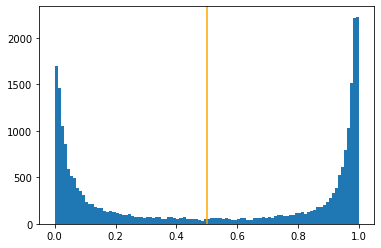

In [14]:
plt.hist(y_hat, bins=100)
_ = plt.axvline(x=0.5, color='orange')

In [15]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'96.15'

In [16]:
# This is the best sentiment classifier out of all of the ones trained, just narrowly beating the regular Sequential() 
# convolutional classifier. The authors of DLI (Deep Learning Illustrated) hypothesize that if the IMDB dataset had been 
# much larger, the Bi-LSTM architectures would have outperformed the convolutional ones.